In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers, models
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pymc as pm
from sklearn.metrics import mean_squared_error, r2_score
import arviz as az
import pytensor.tensor as pt
from scipy.stats import truncnorm, beta

In [2]:
layoffs_df = pd.read_csv("cleaned_layoffs.csv")
X = layoffs_df.drop(columns=['percentage_laid_off'], axis=1)
y = layoffs_df['percentage_laid_off']

X_scaled = MinMaxScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=3)

In [3]:
n_hidden = 16
y_train = np.clip(y_train, 1e-6, 1 - 1e-6)

with pm.Model() as bnn_model:

    X = pm.Data("X", X_train)
    y = pm.Data("y", y_train)

    # Priors
    mu0_1, sigma0_1 = 0.0, 1.0
    w1 = pm.Normal("w1", mu=mu0_1, sigma=sigma0_1, shape=(X.shape[1], n_hidden))

    mu0_2, sigma0_2 = 0.0, 1.0
    w2 = pm.Normal("w2", mu=mu0_2, sigma=sigma0_2, shape=(n_hidden,))

    # Standard deviation prior
    sigma = pm.HalfNormal("sigma", sigma=1.0)

    # One hidden layer with sigmoid activation
    layer_1 = pt.dot(X, w1)
    layer_1_sigmoid = pt.sigmoid(layer_1)
    out = pt.dot(layer_1_sigmoid, w2)
    mu = pm.Deterministic("mu", pt.sigmoid(out)) 

    # Likelihood
    y_obs = pm.TruncatedNormal(
        "y_obs",
        mu=mu,
        sigma=sigma,
        lower=0.0,
        upper=1.0,
        observed=y,
    )

    trace = pm.sample(30000, tune=3000, target_accept=0.95, return_inferencedata=True)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w1, w2, sigma]


Output()

Sampling 4 chains for 3_000 tune and 30_000 draw iterations (12_000 + 120_000 draws total) took 1862 seconds.


        mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd   ess_bulk   ess_tail  \
mu[0]   0.13  0.06    0.02     0.24       0.00      0.0  117421.19  110581.86   
mu[1]   0.01  0.01    0.00     0.03       0.00      0.0  119634.08  115071.91   
mu[2]   0.10  0.06    0.00     0.21       0.00      0.0  110777.08  108554.22   
mu[3]   0.01  0.01    0.00     0.02       0.00      0.0  122046.31  114368.81   
mu[4]   0.06  0.06    0.00     0.17       0.00      0.0  124543.82  112128.60   
...      ...   ...     ...      ...        ...      ...        ...        ...   
w2[11] -0.13  1.48   -2.89     2.59       0.01      0.0   26414.80   56016.47   
w2[12] -0.12  1.48   -2.83     2.64       0.01      0.0   25949.98   55675.87   
w2[13] -0.11  1.48   -2.82     2.65       0.01      0.0   26412.30   55135.21   
w2[14] -0.13  1.47   -2.89     2.58       0.01      0.0   27654.18   56436.65   
w2[15] -0.14  1.48   -2.87     2.61       0.01      0.0   27324.55   57738.58   

        r_hat  
mu[0]     1

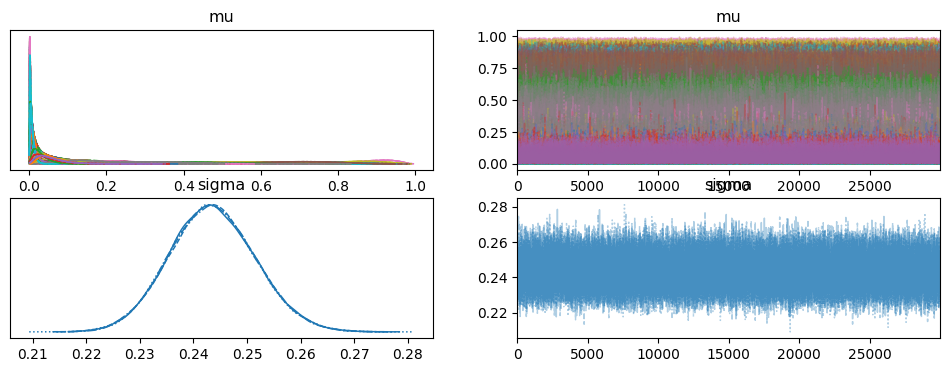

In [5]:
print(az.summary(trace, round_to=2))
az.plot_trace(trace,  var_names=["mu", "sigma"])
plt.show()

In [10]:
#Posterior predictive samples
with bnn_model:
    post_preds = pm.sample_posterior_predictive(trace)

p_test_pred = post_preds.posterior_predictive["y_obs"].mean(dim=["chain", "draw"])
print(f"Posterior R^2 Score: {r2_score(y_train, p_test_pred)}")

Sampling: [y_obs]


Output()

Posterior R^2 Score: 0.2143241787744794


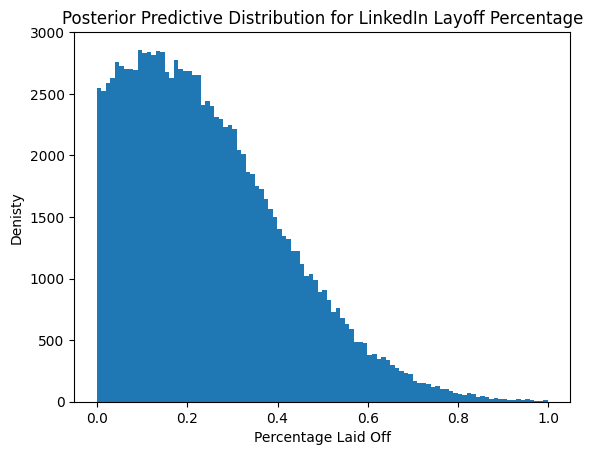

Mean predicted percentage laid off for LinkedIn: 0.24973456916604797
Actual percentage laid off for LinkedIn: 0.3


In [11]:
linkedin_post_preds = post_preds.posterior_predictive["y_obs"][:,:,0].values.ravel()
plt.hist(linkedin_post_preds, bins=100)
plt.title("Posterior Predictive Distribution for LinkedIn Layoff Percentage")
plt.xlabel("Percentage Laid Off")
plt.ylabel("Denisty")
plt.show()
print("Mean predicted percentage laid off for LinkedIn:", np.mean(linkedin_post_preds))
print("Actual percentage laid off for LinkedIn:", 0.3)

(945,)
(945,)


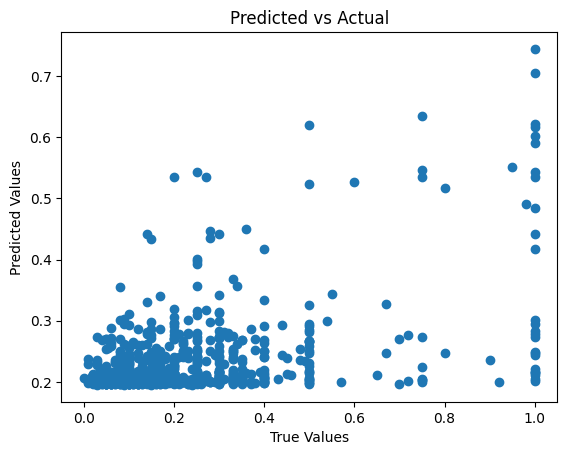

In [12]:
y_pred = post_preds.posterior_predictive['y_obs']
print(np.mean(np.mean(y_pred, axis=0), axis=0).shape)
print(y_train.shape)
plt.scatter(y_train, np.mean(np.mean(y_pred, axis=0), axis=0))
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual')
plt.show()

In [14]:
with bnn_model:
    pm.set_data({"X": X_test, "y": y_test})
    trace.extend(pm.sample_posterior_predictive(trace))
    test_predictions = trace.posterior_predictive["y_obs"].mean(dim=["chain", "draw"])


p_test_pred = trace.posterior_predictive["y_obs"].mean(dim=["chain", "draw"])
print(f"Test set R^2 Score: {r2_score(y_test, test_predictions)}")

Sampling: [w1, y_obs]


Output()

Test set R^2 Score: -0.019997011380537444
